In [1]:
import torch.optim as optim
from torch import nn

from preprocessing_last20 import *
from classifier2 import FaceRecognizer2 as FaceRecognizer
from mindiffusion.ddpm import DDPM
from mindiffusion.unet import NaiveUnet
from torchvision import models

In [2]:
device = torch.device('cpu')
train_data.to(device)
test_data.to(device)
vgg11 = models.vgg11(pretrained=False).to(device)
classifier = FaceRecognizer(vgg11).to(device)
ddpm = DDPM(eps_model=NaiveUnet(1, 1, n_feat=128), betas=(1e-4, 0.02), n_T=600).to(device)
attack_targets = torch.tensor([[0],[1],[2],[3],[4],[5],[6],[7],[8],[9]]).to(device)

In [3]:
classifier.load_state_dict(torch.load('eval_classifier_overfit.pt'))
ddpm.load_state_dict(torch.load('ddpm_batched_600_last20.pth'))

<All keys matched successfully>

In [4]:
def sample_ddpm(noise=None):
    ddpm.eval()
    for param in ddpm.parameters():
        param.requires_grad = False
    torch.random.manual_seed(0)
    xh = ddpm.sample(1, (1, 64, 64), device, noise)
    tensor_to_picture(xh[0].detach().cpu().numpy()[0])
    return xh

In [5]:
for param in classifier.parameters():
    param.requires_grad = False
for param in ddpm.parameters():
    param.requires_grad = False


In [13]:
torch.random.manual_seed(5)
x_i = torch.randn(1, 1, 64, 64).to(device)

In [14]:
x_i.requires_grad = True

In [15]:
def optimize_ddpm_noise(noise, optimizer, criterion, target):
    optimizer.zero_grad()
    generated = sample_ddpm(noise)
    result = classifier(generated)
    loss = criterion(result,attack_targets[target])
    loss.backward()
    optimizer.step()
    return loss.item(), generated, result
def optimize_ddpm_noise_eps(noise, eps, lr, lr_decay, target=8):
    for epoch in range(eps): 
        optimizer = optim.SGD([noise], lr=lr*lr_decay**epoch, momentum=0.0, nesterov=False)
        criterion = nn.CrossEntropyLoss(reduction = 'sum')
        epoch_loss, generated, result = optimize_ddpm_noise(noise, optimizer, criterion, target)
        print("loss(generator): ", epoch_loss)
        print(torch.softmax(result,-1))

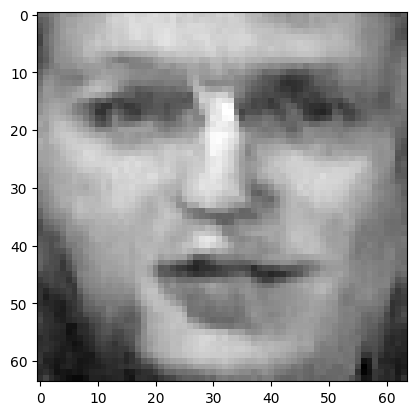

loss(generator):  21.191287994384766
tensor([[3.6184e-07, 4.1925e-07, 2.3352e-06, 1.1517e-04, 9.0601e-05, 2.2389e-09,
         1.6900e-07, 1.0397e-07, 2.0125e-06, 6.2624e-10, 8.4436e-08, 5.9092e-07,
         6.8331e-06, 6.1029e-03, 1.5419e-06, 1.6954e-08, 1.7336e-04, 2.3314e-05,
         1.5862e-06, 2.3610e-08, 2.6647e-03, 4.1741e-06, 8.0450e-01, 4.2605e-06,
         1.1963e-03, 8.7261e-02, 5.8601e-08, 2.4678e-06, 7.0286e-08, 1.3984e-05,
         6.2952e-06, 2.3805e-06, 3.1425e-04, 7.2943e-06, 9.8375e-06, 2.7192e-03,
         9.2330e-02, 2.4400e-03, 7.4500e-07, 8.4666e-07]],
       grad_fn=<SoftmaxBackward>)


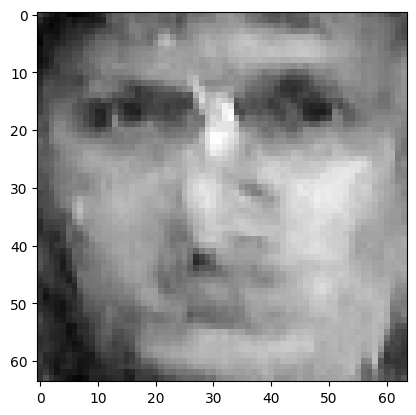

loss(generator):  11.947155952453613
tensor([[2.4701e-05, 2.7448e-05, 2.0923e-04, 5.2009e-04, 1.5163e-03, 7.6001e-06,
         2.4478e-04, 1.9598e-05, 8.9365e-04, 6.4776e-06, 1.3709e-05, 2.0058e-04,
         2.1557e-02, 1.7489e-03, 1.2834e-04, 1.3327e-05, 1.4912e-02, 1.1962e-04,
         3.3095e-04, 3.7259e-04, 1.7518e-01, 1.2852e-04, 2.8310e-01, 3.1071e-04,
         7.3433e-02, 8.1019e-03, 2.1952e-04, 3.7509e-04, 1.0930e-03, 2.6339e-04,
         2.5971e-03, 1.8755e-04, 4.2503e-02, 6.3503e-03, 3.5261e-02, 1.1184e-02,
         3.0961e-01, 7.3143e-04, 5.2364e-03, 1.2624e-03]],
       grad_fn=<SoftmaxBackward>)


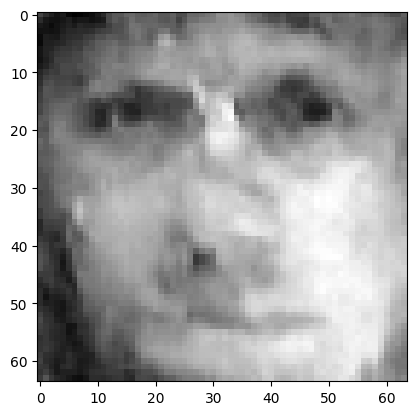

loss(generator):  8.909133911132812
tensor([[3.1924e-04, 2.2573e-04, 2.4431e-03, 1.0626e-03, 4.5212e-03, 2.5648e-04,
         8.3961e-03, 4.1768e-04, 1.1694e-02, 1.3515e-04, 6.4596e-05, 1.1772e-03,
         7.9092e-02, 6.3182e-04, 2.8237e-03, 2.4018e-04, 1.3495e-02, 6.8342e-04,
         2.6151e-03, 2.1782e-02, 1.2412e-01, 1.3829e-03, 1.7961e-02, 3.1049e-03,
         4.8189e-02, 1.3276e-03, 3.7411e-03, 1.6738e-03, 5.1294e-02, 5.8736e-03,
         7.4058e-03, 3.7487e-04, 1.0927e-01, 3.6591e-02, 6.6930e-02, 7.0566e-03,
         1.1246e-02, 2.3088e-04, 3.3531e-01, 1.4836e-02]],
       grad_fn=<SoftmaxBackward>)


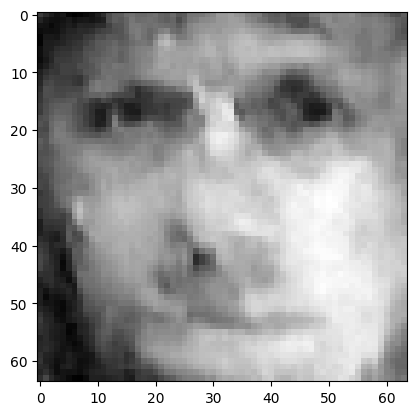

loss(generator):  8.718180656433105
tensor([[3.3864e-04, 2.9946e-04, 1.4394e-03, 2.3415e-03, 5.5451e-03, 5.7245e-04,
         2.8561e-02, 4.3760e-04, 7.0567e-03, 1.6358e-04, 1.2304e-04, 1.4563e-03,
         7.9780e-02, 8.5529e-04, 2.2512e-03, 3.0736e-04, 2.8313e-02, 2.2356e-03,
         6.2034e-03, 1.2912e-02, 1.8235e-01, 6.0544e-04, 5.4368e-02, 2.4976e-03,
         7.9229e-02, 1.6687e-03, 5.9437e-03, 1.8787e-03, 4.5886e-02, 3.5825e-03,
         2.5514e-03, 7.4232e-04, 4.2423e-02, 2.6178e-02, 1.9377e-01, 2.2311e-02,
         2.7488e-02, 6.7062e-04, 1.0852e-01, 1.6143e-02]],
       grad_fn=<SoftmaxBackward>)


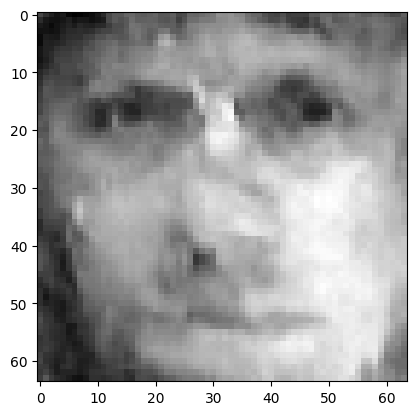

loss(generator):  8.600164413452148
tensor([[3.0807e-04, 2.3287e-04, 1.4302e-03, 1.0881e-03, 3.6702e-03, 1.8816e-04,
         7.6819e-03, 3.6598e-04, 9.5439e-03, 1.8408e-04, 8.9308e-05, 1.3863e-03,
         6.7793e-02, 7.1933e-04, 3.3659e-03, 2.1594e-04, 1.6753e-02, 6.1682e-04,
         2.6672e-03, 1.8855e-02, 1.7403e-01, 1.5473e-03, 2.3180e-02, 4.0594e-03,
         6.9443e-02, 2.0632e-03, 3.4862e-03, 2.1410e-03, 5.1781e-02, 5.8879e-03,
         9.9943e-03, 5.4425e-04, 1.2327e-01, 4.1292e-02, 7.6263e-02, 1.1834e-02,
         2.2400e-02, 3.0624e-04, 2.2773e-01, 1.1595e-02]],
       grad_fn=<SoftmaxBackward>)


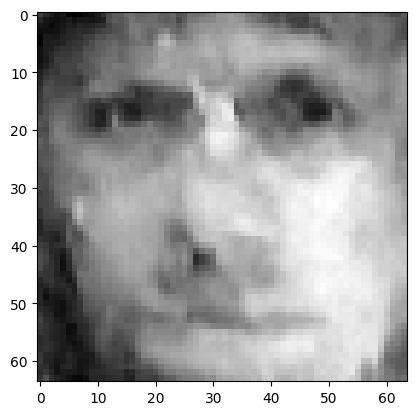

loss(generator):  8.249383926391602
tensor([[0.0003, 0.0005, 0.0009, 0.0023, 0.0051, 0.0004, 0.0199, 0.0005, 0.0071,
         0.0003, 0.0001, 0.0017, 0.0632, 0.0009, 0.0035, 0.0002, 0.0243, 0.0017,
         0.0054, 0.0140, 0.1299, 0.0012, 0.0504, 0.0039, 0.1284, 0.0034, 0.0048,
         0.0022, 0.0488, 0.0055, 0.0053, 0.0018, 0.0722, 0.0394, 0.1351, 0.0550,
         0.0314, 0.0010, 0.1172, 0.0111]], grad_fn=<SoftmaxBackward>)


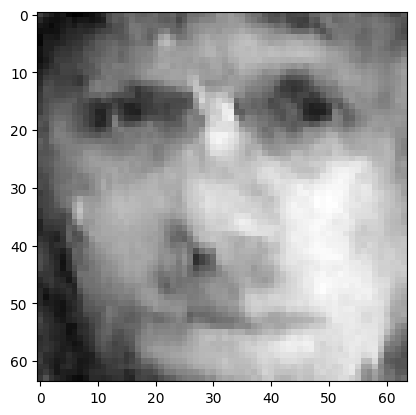

loss(generator):  8.014021873474121
tensor([[0.0003, 0.0006, 0.0008, 0.0021, 0.0042, 0.0004, 0.0158, 0.0005, 0.0073,
         0.0003, 0.0001, 0.0019, 0.0613, 0.0008, 0.0043, 0.0002, 0.0238, 0.0013,
         0.0053, 0.0149, 0.1381, 0.0014, 0.0436, 0.0050, 0.1214, 0.0044, 0.0047,
         0.0024, 0.0573, 0.0064, 0.0073, 0.0019, 0.0757, 0.0408, 0.1235, 0.0583,
         0.0337, 0.0009, 0.1166, 0.0106]], grad_fn=<SoftmaxBackward>)


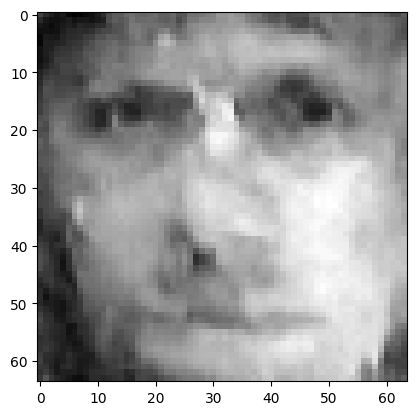

loss(generator):  7.788427352905273
tensor([[0.0002, 0.0007, 0.0005, 0.0017, 0.0032, 0.0003, 0.0145, 0.0004, 0.0048,
         0.0004, 0.0001, 0.0021, 0.0518, 0.0008, 0.0053, 0.0002, 0.0276, 0.0010,
         0.0058, 0.0118, 0.1370, 0.0013, 0.0444, 0.0058, 0.1189, 0.0069, 0.0048,
         0.0022, 0.0592, 0.0061, 0.0075, 0.0032, 0.0781, 0.0336, 0.1235, 0.0902,
         0.0444, 0.0011, 0.0901, 0.0086]], grad_fn=<SoftmaxBackward>)


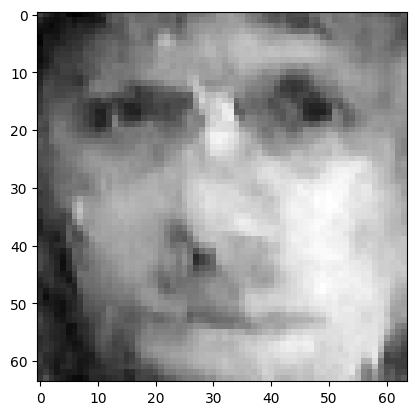

loss(generator):  7.683660984039307
tensor([[0.0003, 0.0007, 0.0005, 0.0019, 0.0038, 0.0004, 0.0287, 0.0005, 0.0052,
         0.0005, 0.0002, 0.0021, 0.0543, 0.0008, 0.0068, 0.0002, 0.0238, 0.0018,
         0.0067, 0.0160, 0.1279, 0.0009, 0.0320, 0.0054, 0.1107, 0.0040, 0.0069,
         0.0025, 0.0791, 0.0057, 0.0043, 0.0039, 0.0728, 0.0307, 0.1370, 0.0875,
         0.0281, 0.0012, 0.0941, 0.0101]], grad_fn=<SoftmaxBackward>)


In [ ]:
torch.random.manual_seed(5)
x_i_lr1 = torch.randn(1, 1, 64, 64).to(device)
x_i_lr1.requires_grad = True
optimize_ddpm_noise_eps(x_i_lr1, 10, 1, 1, target=9)

In [19]:
torch.save(x_i_lr1, 'attack9_lr1_10eps_overfit.pt')

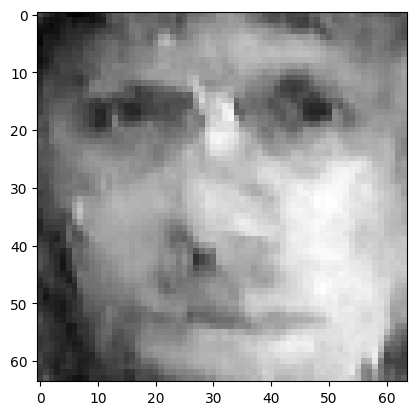

loss(generator):  7.681488990783691
tensor([[2.3446e-04, 5.8589e-04, 5.3361e-04, 1.3888e-03, 2.5793e-03, 2.7435e-04,
         1.2952e-02, 3.9880e-04, 6.6223e-03, 4.6129e-04, 1.4088e-04, 2.1238e-03,
         6.1029e-02, 6.8149e-04, 5.1389e-03, 1.8977e-04, 2.1495e-02, 5.9428e-04,
         5.1537e-03, 1.7382e-02, 1.6087e-01, 1.4442e-03, 2.8845e-02, 6.8509e-03,
         8.7282e-02, 5.8724e-03, 5.1321e-03, 2.4533e-03, 7.9520e-02, 6.5868e-03,
         9.9595e-03, 2.2234e-03, 9.4388e-02, 3.4725e-02, 1.0654e-01, 5.0267e-02,
         3.6574e-02, 6.3117e-04, 1.2983e-01, 1.0044e-02]],
       grad_fn=<SoftmaxBackward>)


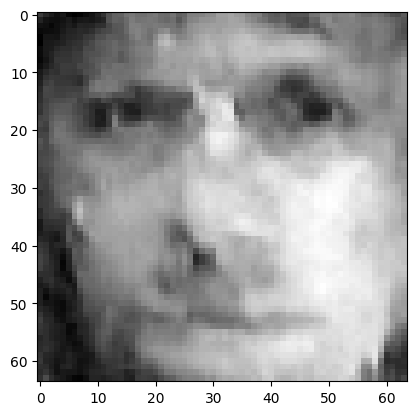

loss(generator):  7.7818498611450195
tensor([[0.0003, 0.0007, 0.0004, 0.0024, 0.0038, 0.0007, 0.0651, 0.0004, 0.0038,
         0.0004, 0.0003, 0.0022, 0.0559, 0.0008, 0.0050, 0.0003, 0.0239, 0.0037,
         0.0113, 0.0160, 0.1279, 0.0004, 0.0282, 0.0037, 0.0743, 0.0017, 0.0114,
         0.0017, 0.0896, 0.0031, 0.0016, 0.0055, 0.0527, 0.0175, 0.1812, 0.1017,
         0.0222, 0.0014, 0.0644, 0.0125]], grad_fn=<SoftmaxBackward>)


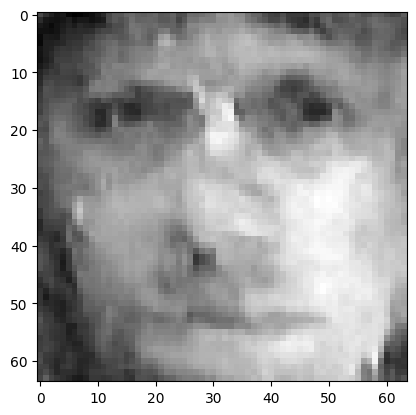

In [ ]:
optimize_ddpm_noise_eps(x_i_lr1, 10, 1, 1, target=9)

In [ ]:
torch.save(x_i_lr1, 'attack9_lr1_20eps_overfit.pt')

In [ ]:
optimize_ddpm_noise_eps(x_i_lr1, 10, 1, 1, target=9)

In [ ]:
torch.save(x_i_lr1, 'attack9_lr1_30eps_overfit.pt')

In [ ]:
optimize_ddpm_noise_eps(x_i_lr1, 10, 1, 1, target=9)

In [ ]:
torch.save(x_i_lr1, 'attack9_lr1_40eps_overfit.pt')

In [ ]:
optimize_ddpm_noise_eps(x_i_lr1, 10, 1, 1, target=9)

In [ ]:
torch.save(x_i_lr1, 'attack9_lr1_50eps_overfit.pt')